# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [1]:
import pandas as pd  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF

import seaborn as sns

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

In [2]:
seaLevel = pd.read_csv("sealevel.csv")
#seaLevel.describe()
seaLevel.head()

,Altimeter type,Merged file cycle nr,Year,Nr observations,Weighted nr observations,GMSL,GMSL std,GMSL smooth,GIA,GIA std,GIA smooth,GIA smooth cycle removed
0,0.0,11.0,1993.011526,466462.0,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
1,0.0,12.0,1993.038692,460889.0,334037.31,-40.35,95.39,-38.20,-40.34,95.39,-38.19,-38.06
2,0.0,13.0,1993.065858,472123.0,342416.09,-40.17,92.29,-38.28,-40.16,92.29,-38.27,-37.60
3,0.0,14.0,1993.093025,421377.0,306050.59,-41.92,96.20,-38.56,-41.89,96.19,-38.54,-37.45
4,0.0,15.0,1993.120191,459548.0,331094.09,-36.89,94.64,-37.87,-36.85,94.63,-37.83,-36.44


In [3]:
obs=seaLevel.shape[0]  # observations
print(f"observations in total is {obs}")

observations in total is 997


Text(0.5, 0.98, 'GMSL vs Time')

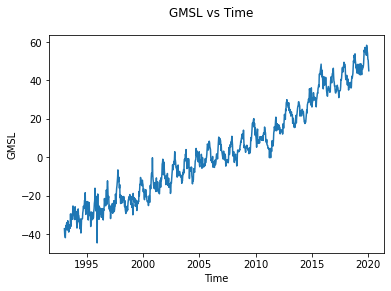

In [4]:
plt.plot(seaLevel['Year'] ,  seaLevel['GMSL'])
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.suptitle("GMSL vs Time")

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:**

according to the assumption of AR， the data modelled should be weakly stationary， including the condition that mean value is const. So the trend needs to be removed

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Substract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

In [5]:
#Fit a straight line
X = seaLevel['Year'].to_numpy().reshape(-1, 1)
y = seaLevel['GMSL'].to_numpy()#.reshape((-1 ,1))
reg = lm.LinearRegression().fit(X, y)

In [6]:
reg.coef_

array([3.06377402])

In [7]:
reg.intercept_

-6144.593649088425

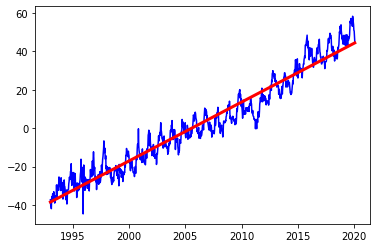

In [8]:
#plot the fitted line
ypred = reg.predict(X)
plt.plot(X, y,  color='blue')
plt.plot(X, ypred, color='red', linewidth=3)

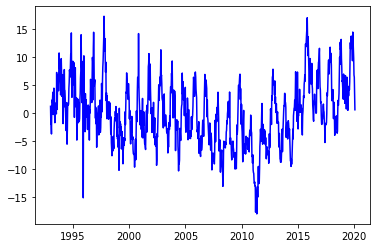

In [9]:
#Substract the fitted line from  𝑦𝑡  for the whole data series and plot the deviations from the straight line.
r=y.shape[0]
detrended = (y - ypred)#.reshape(r,1)
plt.plot(X,detrended, color='blue')

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

In [10]:
#Split the (detrended) time series into training and validation sets.
L_part=700

# splitting the feature
X_train = X[0:L_part,]
X_valid = X[L_part:,]

# splitting the target
y_train = detrended[0:L_part,]
y_valid = detrended[L_part:,]

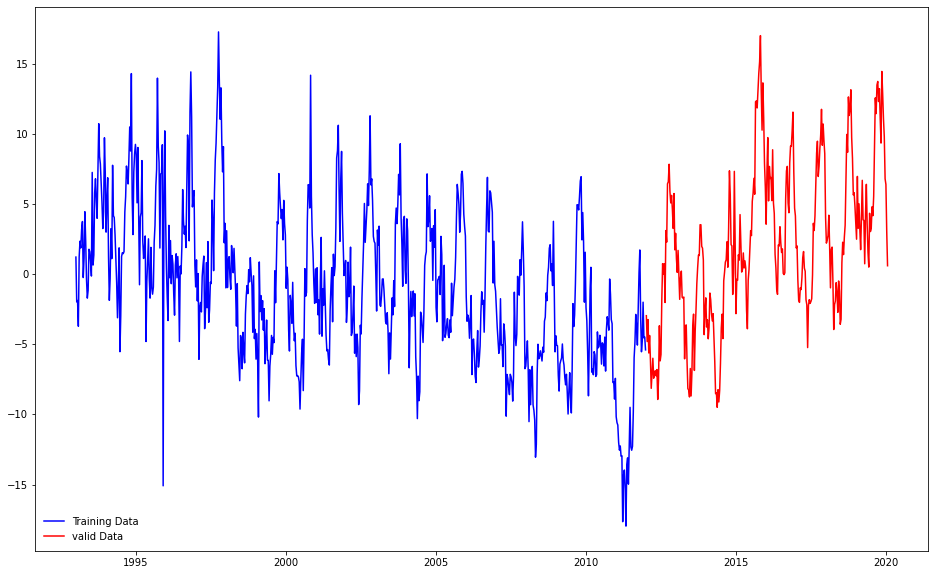

In [11]:
#  Plot the two data sets.
plt.figure(figsize=(16,10))
plt.plot(X_train,y_train, color='blue',label = "Training Data")
plt.plot(X_valid,y_valid, color='red',label = "valid Data")
plt.legend(loc='lower left', frameon=False)

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

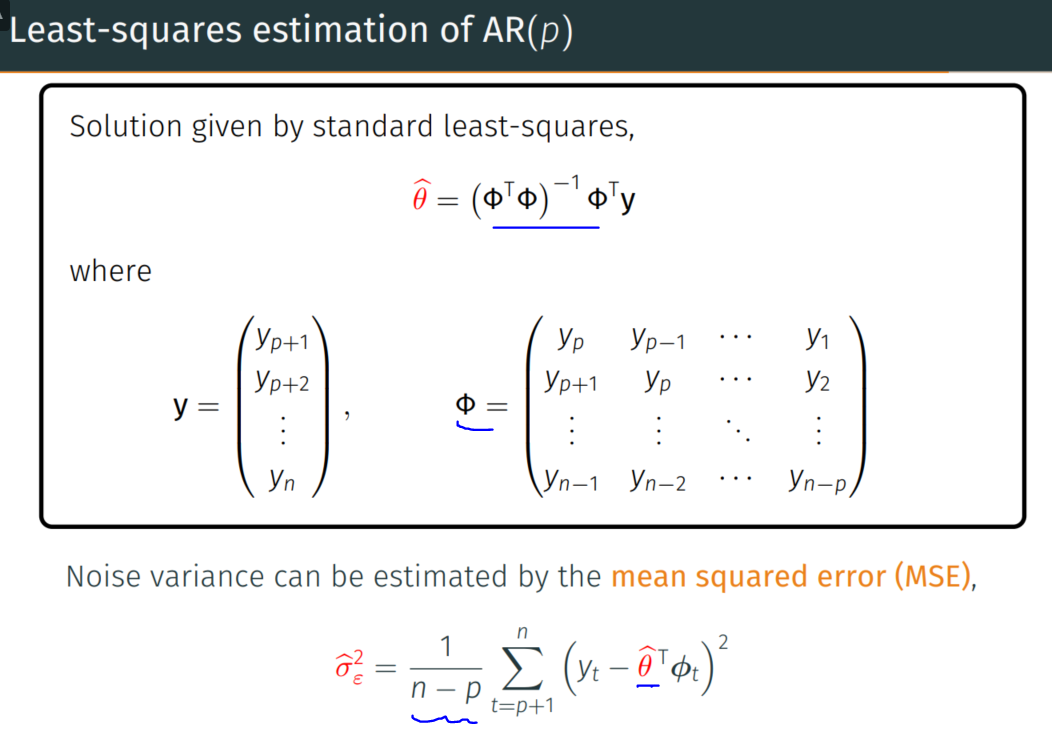

In [12]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = y.shape[0] # <COMPLETE THIS LINE>
    
    # Construct the regression matrix  dfd
    Phi = np.zeros((n-p,p)) # <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,j] =y[j:n+j-p] #y[p-j:n-j]  #y[j:n+j-p] # <COMPLETE THIS LINE>   
        # for p-order, from t-p to t-1, otherwise, near AR(1), the closest one
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [13]:
p=10
theta_hat = fit_ar(y_train,p )
theta_hat

array([ 0.02305208, -0.11175939,  0.07585221, -0.09578106, -0.05955406,
       -0.02184709,  0.1745703 ,  0.15104657,  0.10763277,  0.62156052])

**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [14]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m)
    
    for i in range(m):
        # <COMPLETE THIS CODE BLOCK>
        y_pred[i] = np.dot(theta,y_target[i:p+i]) #... # <COMPLETE THIS LINE> if matrix, use a@b
        
    return y_pred

In [15]:
YPred_train = predict_ar_1step(theta = theta_hat , y_target = y_train)
YPred_valid = predict_ar_1step(theta = theta_hat , y_target = y_valid)

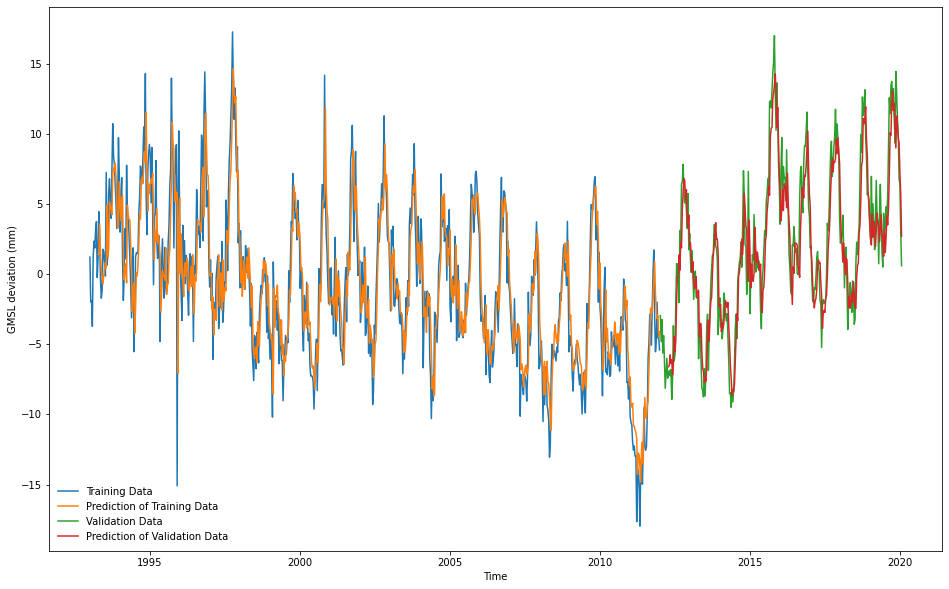

In [16]:
#plotting of predicted values for train and validation data 
plt.figure(figsize=(16,10))
plt.plot(X_train , y_train , label = "Training Data")
plt.plot(X_train[p:,] , YPred_train, label = "Prediction of Training Data")
plt.plot(X_valid , y_valid , label = "Validation Data")
plt.plot(X_valid[p:,] , YPred_valid , label = "Prediction of Validation Data")
plt.xlabel("Time")
plt.ylabel('GMSL deviation (mm)')
plt.legend(loc='lower left', frameon=False)

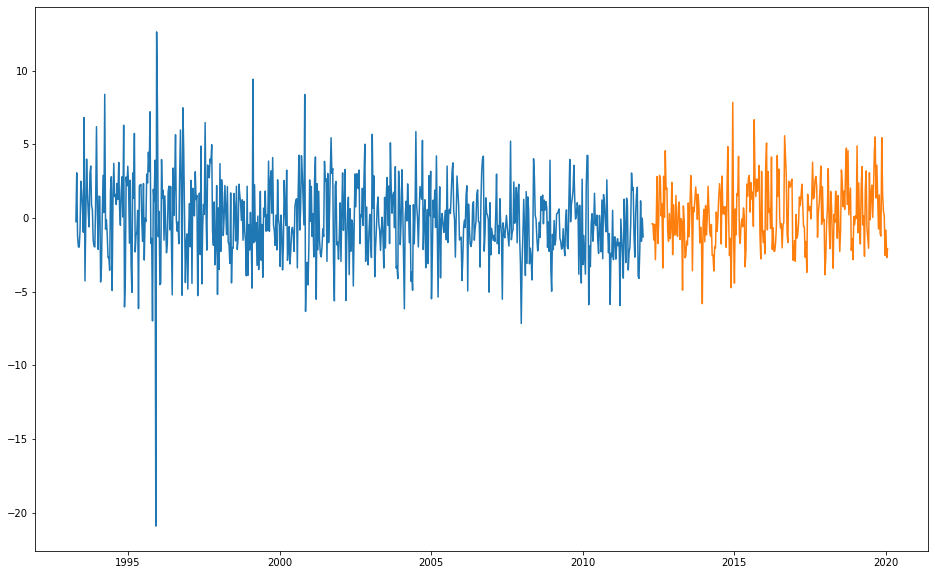

In [17]:
# plot the residuals
plt.figure(figsize=(16,10))
train_residual = y_train[p:,]-YPred_train
valid_residual = y_valid[p:,]- YPred_valid

#plt.subplot(211)
plt.plot(X_train[p:,],train_residual)
#plt.subplot(212)
plt.plot(X_valid[p:,],valid_residual)

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

In [18]:
help(acfplot)

Help on function acfplot in module tssltools_lab1:

acfplot(x, lags=None, conf=0.95)
    Plots the empirical autocorralation function.
    
    :param x: array (n,), sequence of data points
    :param lags: int, maximum lag to compute the ACF for. If None, this is set to n-1. Default is None.
    :param conf: float, number in the interval [0,1] which specifies the confidence level (based on a central limit
                 theorem under a white noise assumption) for two dashed lines drawn in the plot. Default is 0.95.
    :return:



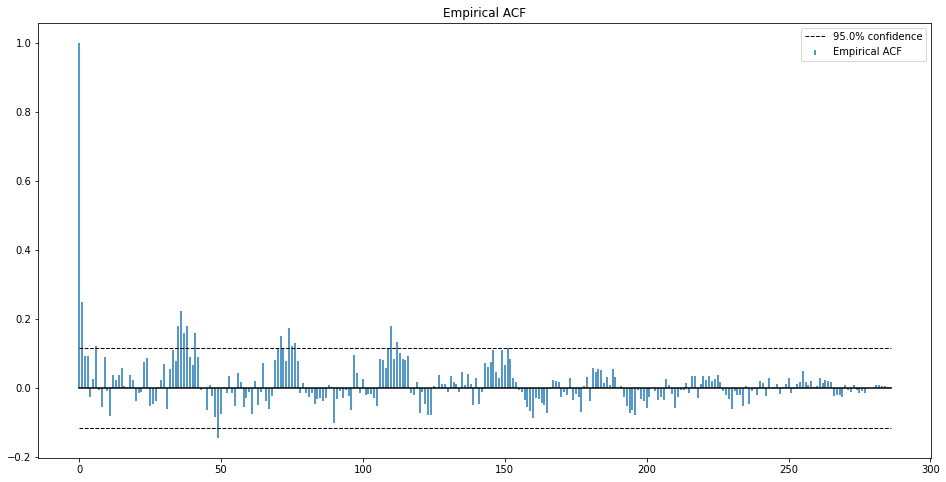

In [19]:
plt.figure(figsize=(16,8))
#sns.set_style('whitegrid')
#plt.subplot(221)
acfplot(x = valid_residual)
# values are not stable, not following the assumption of AR(p)

For lag=none, the ASF is actually the variance of the normalized residual values
(1)95% of the variance are in a fixed range, 
(2) with time's going on, the variance tend to be zero
so by (1)and (2), the residual distribution approximates to be white noise

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

In [20]:
MSE_train = []
MSE_valid = []

for p in range(2,151):
    #calculate theta_hat
    theta_hat = fit_ar(y_train, p)
    #pred for train Data
    predYtrain = predict_ar_1step(theta = theta_hat , y_target = y_train)
    residualsYtrain  = y_train[p:] - predYtrain
    MSE_train.append(sum(residualsYtrain**2) / len(residualsYtrain))

    #pred for Valid Data
    predYValid = predict_ar_1step(theta = theta_hat , y_target = y_valid)
    residualsYvalid  = y_valid[p:] - predYValid
    MSE_valid.append(sum(residualsYvalid**2) / len(residualsYvalid))    

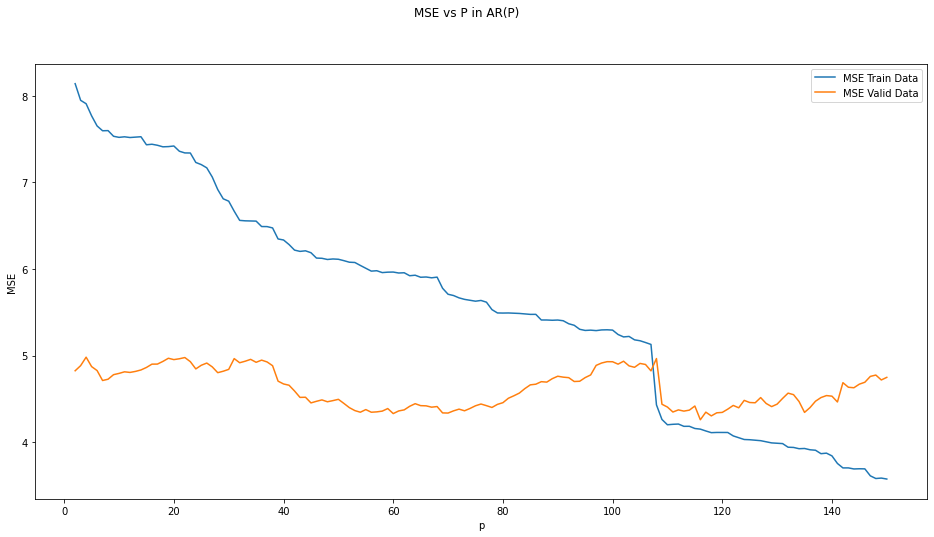

In [21]:
plt.figure(figsize=(16,8))
plt.plot(range(2,151) , MSE_train , label = "MSE Train Data")
plt.plot(range(2,151) , MSE_valid , label = "MSE Valid Data")
plt.xlabel("p")
plt.ylabel("MSE")
plt.suptitle("MSE vs P in AR(P)")
plt.legend()

**What is the main difference between the changes in training error and validation error as the order increases?**

In trend, training data MSE decreases with orders' increasing, but in valid data, MSE stays stable with some fluctuations,after 60 or so, begins to rise, and in 110 or so, it drops and then slowly going up

Based on this, I'll choose p=60

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

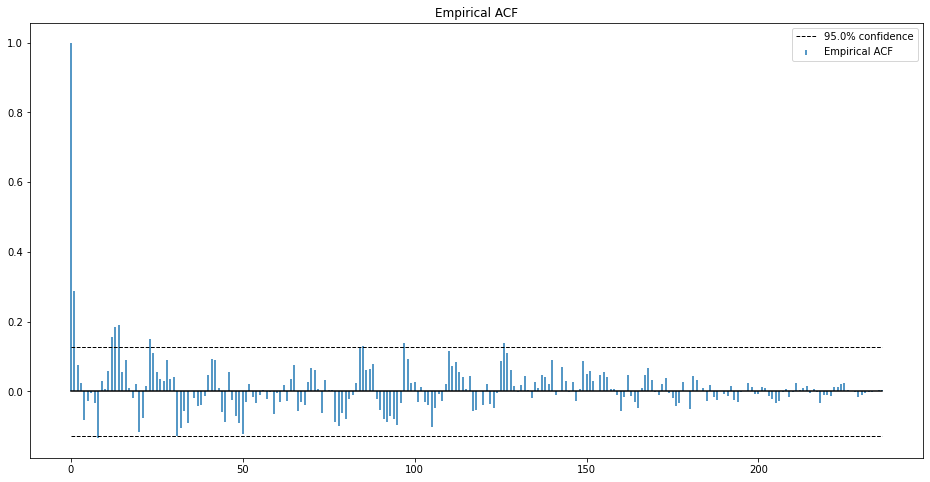

In [24]:
p1 =60
plt.figure(figsize=(16,8))
#calculate theta_hat
theta_hat = fit_ar(y_train, p1)
#pred for Valid Data
predYValid = predict_ar_1step(theta = theta_hat , y_target = y_valid)
residualsValid_p1  = y_valid[p1:] - predYValid
acfplot(x = residualsValid_p1)

Since using a relatively apt p, the residuals are  

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [28]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    
    theta = np.flip(theta.copy())  ##the order matters

    for i in range(m):
        y_sim[i] = np.dot(theta,phi)#... # <COMPLETE THIS LINE>
        phi = np.append(y_sim[i],phi[:len(phi)-1]) # <COMPLETE THIS CODE BLOCK>
    
    return y_sim
    

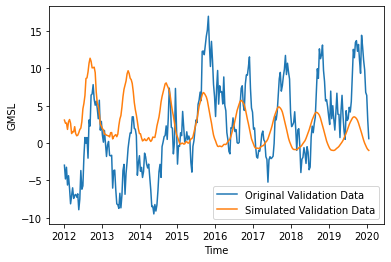

In [29]:
theta_1 = fit_ar(y = y_train , p = p1)
m = len(y) - len(y_train)

y_sim_pred_valid = simulate_ar( y = y_valid , theta = theta_1 , m = m)

plt.plot(X_valid , y_valid , label = "Original Validation Data")
plt.plot(X_valid , y_sim_pred_valid , label = "Simulated Validation Data")

#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.legend()

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

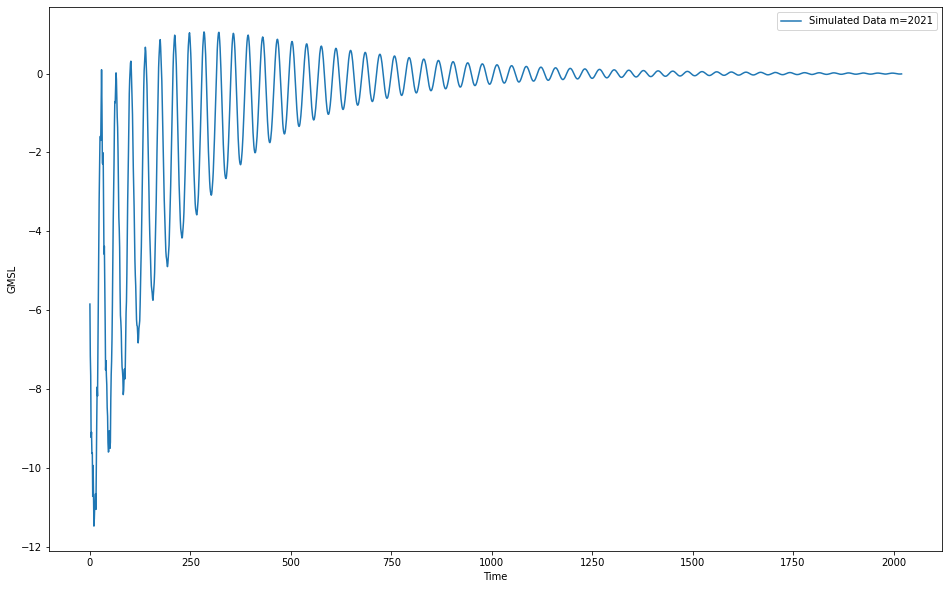

In [27]:
m=2021
theta = fit_ar(y_train,60)
sim = simulate_ar( y_train ,theta , m)
plt.figure(figsize=(16,10))
plt.plot(range(m) , sim , label = "Simulated Data m="+str(m))
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.legend()

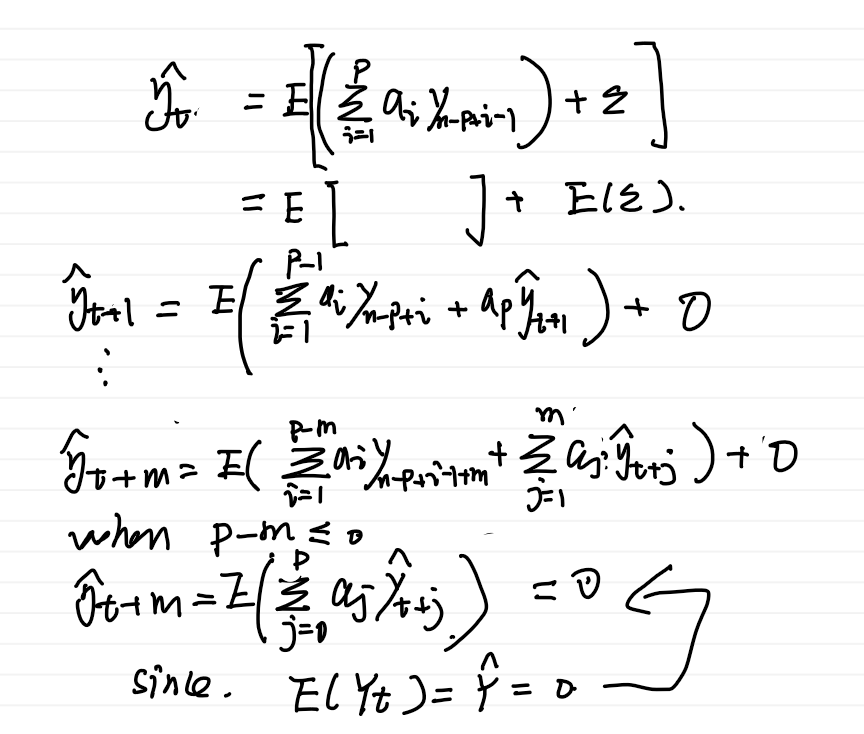

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [135]:
def Phi_get(y , p):
    n = y.shape[0]
    Phi = np.zeros((n-p,p), dtype= float)
    for j in range(p):
        Phi[:,j] = y[j:(n+j-p)]
    return Phi

p = p1#60
yModel = y_train[p:]  

model = MLPRegressor(hidden_layer_sizes=(10,) , activation= "relu",max_iter=2000)
reg = model.fit(Phi_get(y = y_train , p = p), yModel)
n = y_train.shape[0]
dataValid_Y = np.append(y_train[(n - p): ] , y_valid)# last p in tr +　ｙ＿ｖａｌ
predictedVal = reg.predict(Phi_get(y = dataValid_Y , p = p))

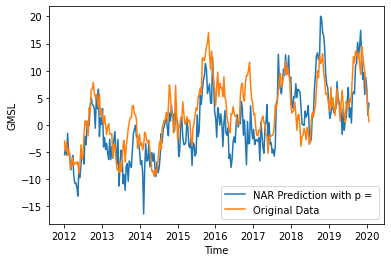

In [136]:
plt.plot(X_valid , predictedVal , label = "NAR Prediction with p = ")
plt.plot(X_valid , y_valid , label = "Original Data")
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.legend()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**